In [1]:
# import libraries
import os
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle5 as pickle

import helpers as helper

In [2]:
# load data
with open('../../data/customer/WM-unlabeled-random50-314.pkl', "rb") as fh:
    data = pickle.load(fh)

print(data.shape)
data.head()

(1250, 5)


,ID,waferMap,dieSize,lotName,waferIndex
0,29288,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3031,lot3405,1
1,29289,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3031,lot3405,2
2,29290,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3030,lot3405,3
3,29291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3030,lot3405,4
4,29292,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3031,lot3405,5


In [3]:
# load predictions
with open('../results/yutandem-224thin2-unlabeled-random314.pkl', "rb") as fh:
    predictions = pickle.load(fh)

defect_ids = predictions[0]
detect_probs = predictions[1]
classify_probs = predictions[2]
labels = predictions[3]
    
# sanity check
print(f'Detected defective wafers: {len(defect_ids)}')
print(f'Detect probabilities length: {len(detect_probs)}')
print(f'Classify probabilities length: {len(classify_probs)}')
print(f'Labels length: {len(labels)}')

Detected defective wafers: 126
Detect probabilities length: 1250
Classify probabilities length: 126
Labels length: 1250


In [4]:
# probabilities for the highest class for each model
detect_max_prob = [max(x) for x in detect_probs]
classify_max_prob = [max(x) for x in classify_probs]

# second highest class for defective sample
classify_label2 = [x.argsort()[-2] for x in classify_probs]

# second highest class probability
classify_max_prob2 = [x[i] for x, i in zip(classify_probs, classify_label2)]

In [5]:
# add columns to dataframe
data['pred_labels'] = labels

# add column of probabilities predicted class 
def add_max_prob(row):
    i = row.name
    if row['pred_labels'] == 8:
        return detect_max_prob[i] * 100
    else:
        j = defect_ids.index(data.ID[i])
        return (detect_max_prob[i] * classify_max_prob[j]) * 100

data['pred_prob'] = data.apply(lambda row: add_max_prob(row), axis=1)

# add column for second prediction, if defective
# if not defective, second prediction = 8
def second_prediction(row):
    i = row.name
    if row['pred_labels'] == 8:
        return 8
    else:
        j = defect_ids.index(data.ID[i])
        return classify_label2[j]

data['pred2_labels'] = data.apply(lambda row: second_prediction(row), axis=1)

# add column of probabilities for second highest class, if defective
# if not defective, second probability = 0
def add_second_prob(row):
    i = row.name
    if row['pred_labels'] == 8:
        return 0
    else:
        j = defect_ids.index(data.ID[i])
        return (detect_max_prob[i] * classify_max_prob2[j]) * 100

data['pred2_prob'] = data.apply(lambda row: add_second_prob(row), axis=1)

data.head()

,ID,waferMap,dieSize,lotName,waferIndex,pred_labels,pred_prob,pred2_labels,pred2_prob
0,29288,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3031,lot3405,1,8,99.913067,8,0.0
1,29289,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3031,lot3405,2,8,99.999774,8,0.0
2,29290,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3030,lot3405,3,8,99.999964,8,0.0
3,29291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3030,lot3405,4,8,99.999976,8,0.0
4,29292,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3031,lot3405,5,8,95.409411,8,0.0


In [6]:
def defect_distribution(data, note=''):
    """Helper function to visualize distribution of defects
       :param mode -> str | classify or detect"""
    
    # count how many of each defect is present
    dist = data.groupby('pred_labels')['pred_labels'].count().sort_values()
    y = dist.tolist()

    fail_dict = {8: 'none', 0: 'Loc', 1: 'Edge-Loc', 2: 'Center', 3: 'Edge-Ring', 
                 4: 'Scratch', 5: 'Random', 6: 'Near-full', 7: 'Donut'}
    indices = dist.index.tolist()
    x = [fail_dict[i] for i in indices]
      
    # bar plot
    plt.barh(x, y)
    xlim = math.ceil(max(y)*1.15)
    plt.xlim(0, xlim)
    plt.title(f'Failure Type Distribution\n({note})')

    for index, value in enumerate(y):
        plt.text(value, index,
                 str(value))

    plt.show()

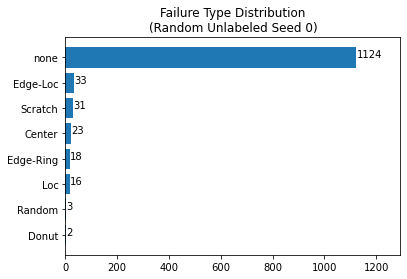

In [7]:
# distribution of labels
defect_distribution(data, note='Random Unlabeled Seed 0')

In [8]:
# count how many defective wafers in each lot
# list of unique lots
unique_lots = data.lotName.unique()

lot_count = {x:0 for x in unique_lots}
for i in range(len(data)):
    if data.pred_labels[i] != 8:
        lot_count[data.lotName[i]] += 1

data['lot_defect_ct'] = data.lotName.apply(lambda x: lot_count[x])
data.head()

,ID,waferMap,dieSize,lotName,waferIndex,pred_labels,pred_prob,pred2_labels,pred2_prob,lot_defect_ct
0,29288,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3031,lot3405,1,8,99.913067,8,0.0,1
1,29289,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3031,lot3405,2,8,99.999774,8,0.0,1
2,29290,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3030,lot3405,3,8,99.999964,8,0.0,1
3,29291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3030,lot3405,4,8,99.999976,8,0.0,1
4,29292,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3031,lot3405,5,8,95.409411,8,0.0,1


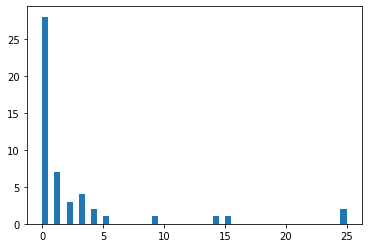

In [9]:
plt.hist(lot_count.values(), 50)
pass

In [24]:
def plot_lot(df1, lot, fig_size=(10, 10), col='waferMap', cmap='viridis'):
    """
    Helper function to plot entire lot of wafers from df1.
    Lots must have >= 2 samples.
    
    :param lot: -> str | lotName that will be plotted e.g. 'lot1'
    :param fig_size: -> tuple | size of plot
    :param col: -> str | column that contains waferMap image
    :param cmap: -> str | color scheme to use
    """
    
    lot_df = df1[df1['lotName'] == lot]
    lot_df.reset_index(inplace=True)

    total_rows = len(lot_df.index)
    ax_cnt = 5
    
    print(f'{lot}')
    
    fail_dict = {8:'None', 0:'Loc', 1:'Edge-Loc', 2:'Center', 3:'Edge-Ring', 
             4:'Scratch', 5:'Random', 6:'Near-full', 7:'Donut'}

    fig, axs = plt.subplots(ax_cnt, ax_cnt, figsize=fig_size)
    fig.tight_layout()

    # Nested for loops to loop through all digits and number of examples input for plotting
    for n_row in range(25):
        if n_row < total_rows:
            img = lot_df[col][n_row]
            index = lot_df["ID"][n_row]
            ftype = fail_dict[lot_df.pred_labels[n_row]]
            pct = lot_df.pred_prob[n_row]
                
        else:
            img = np.zeros_like(lot_df[col][0])
            index = ''
            ftype = ''
            pct = ''

        # imshow to plot image in axs i,j location in plot
        i = n_row % ax_cnt
        j = int(n_row/ax_cnt)
        axs[i, j].imshow(img,
                         interpolation='none',
                         cmap=cmap, vmax=2)
        axs[i, j].axis('off')

        # label the figure with the index# and defect classification [for future reference]
        if ftype != 'None':
            axs[i, j].set_title(f'{index}: {ftype}\n{pct:.2f}%', fontsize=10, color='red')
        else:
            axs[i, j].set_title(f'{index}: {ftype}\n{pct:.2f}%', fontsize=10)

    plt.show()

In [25]:
lot_count

{'lot3405': 1,
 'lot3562': 0,
 'lot3968': 0,
 'lot4001': 3,
 'lot7124': 0,
 'lot7473': 1,
 'lot10097': 1,
 'lot11007': 2,
 'lot12090': 0,
 'lot12097': 0,
 'lot12394': 0,
 'lot14362': 1,
 'lot14519': 0,
 'lot15386': 25,
 'lot15926': 2,
 'lot16087': 0,
 'lot16995': 15,
 'lot17070': 0,
 'lot17758': 0,
 'lot18188': 0,
 'lot18254': 0,
 'lot18534': 0,
 'lot19173': 1,
 'lot19257': 0,
 'lot19382': 0,
 'lot19680': 0,
 'lot20759': 0,
 'lot21687': 4,
 'lot21946': 25,
 'lot22354': 0,
 'lot22484': 0,
 'lot23142': 0,
 'lot24621': 1,
 'lot25286': 0,
 'lot25429': 0,
 'lot27659': 0,
 'lot27754': 2,
 'lot28465': 0,
 'lot28705': 3,
 'lot30022': 0,
 'lot32703': 9,
 'lot33532': 3,
 'lot34809': 14,
 'lot35791': 4,
 'lot38687': 0,
 'lot38785': 1,
 'lot39671': 5,
 'lot39886': 0,
 'lot39893': 0,
 'lot41583': 3}

lot12097


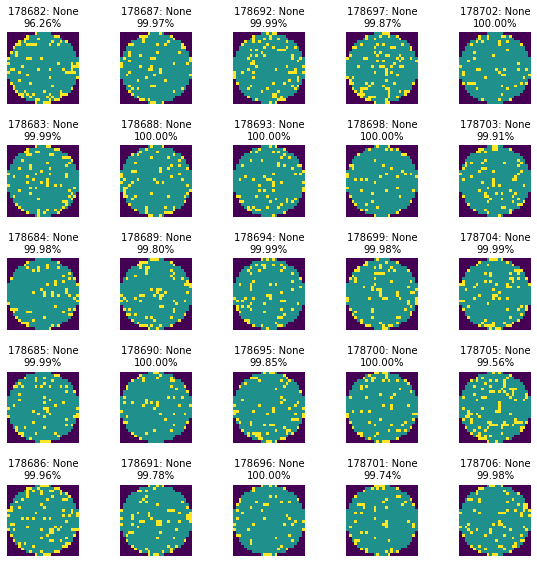

In [26]:
plot_lot(data, 'lot12097', fig_size=(8,8))

lot12090


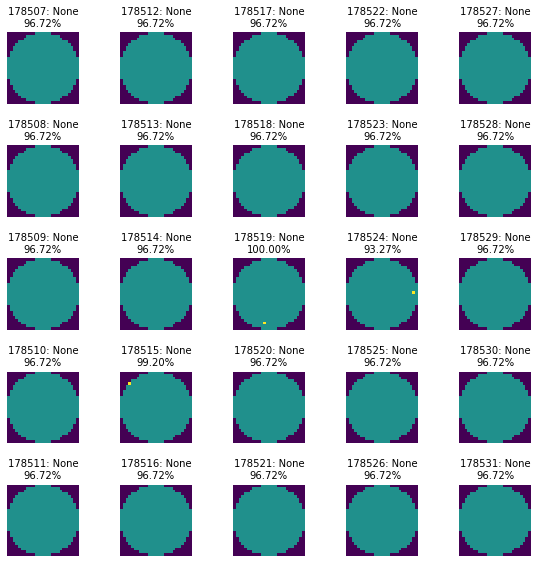

In [27]:
plot_lot(data, 'lot12090', fig_size=(8,8))

lot34809


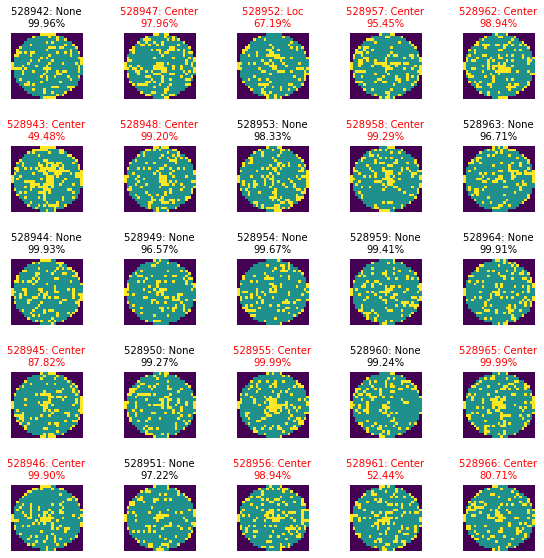

In [29]:
plot_lot(data, 'lot34809', fig_size=(8,8))

In [30]:
data.loc[data.ID == 528961]

,ID,waferMap,dieSize,lotName,waferIndex,pred_labels,pred_prob,pred2_labels,pred2_prob,lot_defect_ct
1069,528961,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2,...",515,lot34809,20,2,52.441221,0,0.079533,14
